### Imports

In [54]:
import pandas as pd
import nltk, re, string
import numpy as np
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn import svm
from nltk.corpus import stopwords

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import StratifiedKFold
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re, collections
from nltk.corpus import words as w

/Users/NiaVivek/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Preprocess Data

Read the csv file and make a dataframe.
- For training: Randomize and Divide it into 80:20 partitions

In [55]:
def load_Dataset(run="train"):
    df = pd.read_csv("train.csv")
    df = df[df["Comment"].notnull()]
    df.apply(np.random.permutation)
    if run=="train":
        df_train = df[:round(0.8*len(df))]
        df_test = df[round(0.8*len(df)):]
    elif run=="test":
        df_train = df
        df_test = pd.read_csv("test_with_solutions_2.csv")
    return df_train, df_test

### Tokenization

This function takes a text and does the following to return the tokens:
* Use nltk's TweetTokenizer to get tokens
* Use wordNetLemmatizer for lemmatization
* Use porterStemmer to stem the resulting tokens

In [56]:
def words(text):
    return re.findall('[a-z]+', text.lower())

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1   
    return model

with open("big.txt", "r") as big:
    word_corpus = big.read()
for word in w.words():
    word_corpus += word
    

NWORDS = train(words(word_corpus))
with open("list_of_abuses.txt", "r") as abuse_list:
    abuses = abuse_list.read().split()
    for abuse in abuses:
        NWORDS[abuse] = 100

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
#     print(word)
    s = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [a + b[1:] for a, b in s if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in s if len(b)>1]
    replaces   = [a + c + b[1:] for a, b in s for c in alphabet if b]
    inserts    = [a + c + b     for a, b in s for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words):
    try:
        return [int(w) for w in words] #to take care of purely numeric words
    except:
        return set(w for w in words if w.lower() in NWORDS)

def correct(word):
    if word[0] not in alphabet: 
        return word
    else:
        word = re.sub(r'(.)\1+', r'\1\1', word)
        candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
        return max(candidates, key=NWORDS.get)

In [57]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w!@#$%^&*]+)', # To group symbols together
    r'(?:[\w_]+)', # other words
    
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    tokens = tokens_re.findall(s)
    for i in range(len(tokens)):
        clean_token = correct(tokens[i])
        tokens[i] = clean_token
    return tokens
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [58]:
def build_tokens(text):
#     tweetTokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
#     tokens = tweetTokenizer.tokenize(text)
    tokens = preprocess(text, lowercase=True)
    tokens = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    tokens= [nltk.PorterStemmer().stem(token) for token in tokens]
    return tokens

In [59]:
build_tokens("Your a retard go post your head up your f%&k")

['your', 'a', 'retard', 'go', 'post', 'your', 'head', 'up', 'your', 'fuk']

### Feature Extraction

In [60]:
# tfidf feature extraction and chi2 selection
def feature_extraction(df_train, df_test):
    vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), max_df= 0.5, analyzer= "word", tokenizer= build_tokens ,min_df=10,max_features=10000) #current best for max_features = 4000   
#     count_vectorizer = CountVectorizer(analyzer="word", tokenizer=build_tokens, ngram_range=(1,3), max_features=1000)
    
    X_train = vectorizer.fit_transform(df_train["Comment"]).todense()
    X_test = vectorizer.transform(df_test["Comment"]).todense()

    ch2 = SelectKBest(chi2, k = 'all') #current best for k=2300(0.8815625)
    X_train = ch2.fit_transform(X_train, df_train.Comment)
    X_test = ch2.transform(X_test)
    
    ####### Debug run #######
    # feature_names = vectorizer.get_feature_names()
    # feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
    
    return X_train, X_test

### Classifier

In [61]:
# 
def classify_train(clf_type, X_train, train_category):
    if clf_type == "logreg":
#         logreg = linear_model.LogisticRegression(tol=1e-8, penalty='l2', C=4, max_iter=1000)
        logreg = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
        logreg.fit(X_train, train_category)
        return logreg
    elif clf_type == "svm_rbf":
        clf = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr", probability=True)
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "svm_linear":
        clf = svm.SVC(kernel = 'linear', probability = True)
        clf.fit(X_train, train_category)
        return clf
    elif clf_type == "sgd":
        clf = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        clf.fit(X_train,train_category)
        return clf
    elif clf_type == "nb":
        clf = MultinomialNB()
        clf.fit(X_train,train_category)
        return clf
    elif clf_type == "nn":
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(500,), max_iter=50000, random_state=1)
        clf.fit(X_train,train_category)
        return clf
    # ensemble of different classifiers. We used a soft voting measure to combine the output
    elif clf_type == "ensemble":
        clf1 = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
        clf3 = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr",probability=True)
        clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet', n_jobs=-1)
        clf5 = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(500,), max_iter=50000, random_state=1)
        eclf = VotingClassifier(estimators=[('lr',clf1),('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
        eclf = eclf.fit(X_train,train_category)
        return eclf

##### This function takes a trained classifier and a set of features as input and returns the prediction of the classifier

In [62]:
def classify_predict(clf, X_test):
    predictions = clf.predict(X_test)
    return predictions

def check_val_score(predictions, true_vals):
    return metrics.accuracy_score(true_vals,predictions)

## Function to plot Confusion matrix

In [63]:
def plot_confusion_matrix(cm, title, target_names, cmap=plt.cm.coolwarm):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Pipeline and Adding Custom features

#### Adding additional features

2 custom features are added - percentage of bad words in a sentence as listed in the bad words file and the compound value from vader sentiment analysis.

In [70]:
class AdditionalFeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def get_feature_names(self):
        return (['percent_bad','vader_compound'])
    
    def num_bad(self, df):
        #get number of words in each sentence
        num_words = [len(word) for word in df]
        
        #get percent of abusive words in each sentence
        with open("list_of_abuses.txt", "r") as abuse_list:
            abuses = abuse_list.read().split()
            num_abuses = 0
            for abuse in abuses:
                num_abuses += 1
            # number of badwords in list of abuses
            num_bad = [np.sum([word.lower().count(abuse) for abuse in abuses])
                                                for word in df]
            norm_bad = np.array(num_bad) / np.array(num_words, dtype=np.float)
        return norm_bad
    
    def vader_helper(self, df):
        #vader analysis
        sid = SentimentIntensityAnalyzer()
        vader_feature = []
        for sentence in df:
            ss = sid.polarity_scores(sentence)
            vader_feature.append(ss['compound'])
        return vader_feature
    
    def transform(self, df, y=None):     
        #add both the features to an array
        X = np.array([self.num_bad(df), self.vader_helper(df)]).T
        #X.reshape(-1, 1) #use if only 1 feature
        if not hasattr(self, 'scalar'):
            self.scalar = preprocessing.StandardScaler().fit(X)
        return self.scalar.transform(X)      

    def fit(self, df, y=None):
        return self

In [118]:
def all_features():
    features = []
    custom_features = AdditionalFeatureExtractor() # this class includes my custom features
    features.append(('custom_features', custom_features))

    vect = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), max_df= 0.5, analyzer= "word", tokenizer= build_tokens ,min_df=10,max_features=10000)
    count_vect = CountVectorizer(analyzer="word", tokenizer=build_tokens, ngram_range=(1,1), max_features=1000)
    features.append(('ngram', vect))
    features.append(('count', count_vect))

    all_features = FeatureUnion(features)
    return all_features

In [119]:
def all_classifiers():
    clf1 = linear_model.LogisticRegression(C=8.25, max_iter=3000, tol=1e-8)
    clf3 = svm.SVC(kernel='rbf', gamma=0.8, C=1, decision_function_shape="ovr",probability=True)
    clf4 = linear_model.SGDClassifier(n_iter=2000,loss = 'modified_huber', penalty = 'elasticnet',alpha=0.001, n_jobs=-1)
    #clf5 = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(500,),  max_iter=50000, random_state=1)
    eclf = VotingClassifier(estimators=[('lr',clf1),('svm_rbf',clf3), ('sgd' , clf4)], voting="soft")
    return eclf

### Pipeline

In [120]:
best_clf = Pipeline([
    ('all', all_features() ),
    #('kbest', SelectKBest(chi2, k = 'all')),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('ensemble',all_classifiers()),
    ])

### Testing pipeline and custom features

In [121]:
df_train, df_test = load_Dataset()

In [122]:
best_clf.fit(df_train.Comment,df_train.Insult)
predicted = best_clf.predict(df_test.Comment)

In [123]:
accuracy_score(df_test.Insult,predicted)

0.83523447401774398

In [124]:
class_labels = np.sort(df_train.Insult.unique())
lables = [str(i) for i in class_labels]
print(classification_report(df_test.Insult, predicted, target_names=lables))

             precision    recall  f1-score   support

          0       0.86      0.92      0.89       578
          1       0.73      0.61      0.66       211

avg / total       0.83      0.84      0.83       789



#### Testing on test set - using pipeline and custom

In [125]:
df_train, df_test = load_Dataset("test")

In [126]:
predictions = best_clf.predict(df_test.Comment)

In [127]:
accuracy_score(df_test.Insult,predictions)

0.59451659451659455

In [128]:
print(classification_report(df_test.Insult, predictions, target_names=lables))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.59      0.75       693

avg / total       1.00      0.59      0.75       693



/Users/NiaVivek/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


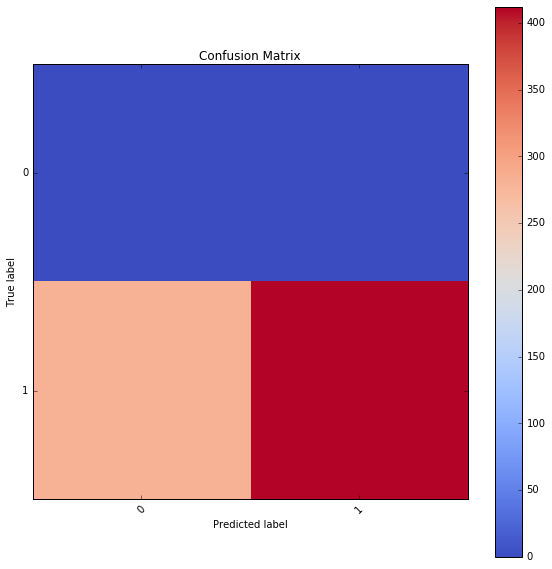

In [129]:
nb_cm = confusion_matrix(df_test.Insult, predictions)
plot_confusion_matrix(nb_cm, "Confusion Matrix", class_labels)

## Getting it all together

### Validation run

In [35]:
df_train, df_test = load_Dataset()
X_train, X_test = feature_extraction(df_train, df_test)

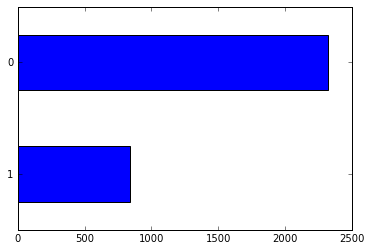

In [36]:
category_counts = df_train["Insult"].value_counts(ascending=True)
category_counts.plot(kind='barh')

In [37]:
clf = classify_train("ensemble", X_train, df_train.Insult)

In [38]:
predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Insult))

0.84030418251


In [39]:
class_labels = np.sort(df_train.Insult.unique())
from sklearn.metrics import classification_report

lables = [str(i) for i in class_labels]
print(classification_report(df_test.Insult, predictions, target_names=lables))

             precision    recall  f1-score   support

          0       0.87      0.92      0.89       578
          1       0.73      0.64      0.68       211

avg / total       0.84      0.84      0.84       789



### Final run 

In [40]:
df_train, df_test = load_Dataset("test")
X_train, X_test = feature_extraction(df_train, df_test)

In [41]:
clf = classify_train("ensemble", X_train, df_train.Insult)

In [42]:
predictions = classify_predict(clf, X_test)
print(check_val_score(predictions, df_test.Insult))

0.606060606061


In [32]:
print(classification_report(df_test.Insult, predictions, target_names=lables))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.62      0.77       693

avg / total       1.00      0.62      0.77       693



/Users/NiaVivek/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### SOME USEFUL CODE

### Code for stratified dataset

This code can be used to determine the best model as there is class imbalance.

In [ ]:
data_set = pd.read_csv("train.csv")
skf = StratifiedKFold(data_set.Insult,n_folds=3)
accuracy = 0
best_model = None
prediction = None
y = None
for train_index, test_index in skf:
    X_train, X_test = data_set.Comment[train_index], data_set.Comment[test_index]
    y_train,y_test = data_set.Insult[train_index], data_set.Insult[test_index]
    # Drop any resulting nan values
    X_train.dropna(inplace=True)
    y_train.dropna(inplace=True)
    X_test.dropna(inplace=True)
    y_test.dropna(inplace=True)
    # Train model using created datasets
    best_clf.fit(X_train, y_train)
    print('Trained model on new train dataset.')
    # Predict on test
    predicted = best_clf.predict(X_test)
    print('Accuracy on test dataset: ')
    test_accuracy = accuracy_score(y_test,predicted)
    print(test_accuracy)
    
    # Save models and accuracy so that we can use it later
    if (test_accuracy > accuracy):
        accuracy = test_accuracy
        best_model = best_clf
        prediction = predicted
        y = y_test

### Sample Code for hyperparameters testing

You can use this code to determine hyperparameters for the classifiers using GridSearch

In [ ]:
best_clf_hyp = Pipeline([('vect', TfidfVectorizer(tokenizer=build_tokens,ngram_range=(1, 3)
                                              , min_df=8
                      ,stop_words=stopwords.words('english'),max_features=5000)),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='elasticnet',alpha=0.0001, n_iter=10, random_state=42)), ])

In [ ]:
parameters = {'vect__ngram_range': [(1, 3)],'vect__min_df':[5,8],'tfidf__use_idf': [True],'clf__alpha': [1e-3,1e-4]
              ,'clf__n_iter':(1000,2000),}
gs_clf = GridSearchCV(best_clf_hyp, parameters, n_jobs=-1)

In [ ]:
gs_clf = gs_clf.fit(df_train.Comment,df_train.Insult)

In [ ]:
print('Best score:',gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))